In [91]:
import pandas as pd
import numpy as np
import json
import re
import pickle
import os
import glob
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, CoherenceModel
from gensim.models import Nmf
from sklearn.decomposition import NMF
import spacy
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import contractions
import string
# import fasttext
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib.pyplot import figure
# !pip install bitermplus
import bitermplus as btm


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [101]:
df = pd.read_pickle("eng_tweets")

df.head()

userid       username  \
0          3700236853  zeitgeist8888   
1          1316226001   BoerjeBrandt   
2           165793361      pollsstar   
3  893458615562096640      agtmewlfy   
4  916681683134447617   MilaPlayporn   

                                            acctdesc           location  \
0  “Freedom must be armed better than tyranny.” –...  Sydney, Australia   
1  Only when the last tree has been cut down, the...       Kåge, Sweden   
2  world traveller, serial hugger, voracious read...            Bedford   
3                                                  ✨              ciel    
4                                                NaN                NaN   

   following  followers  totaltweets               usercreatedts  \
0        367        156        28559  2015-09-27 05:06:53.000000   
1       1505        464        71327  2013-03-30 10:55:40.000000   
2       2546       2844       943527  2010-07-12 15:15:35.000000   
3        662         56         9709  2017-08-04 13:08:28.000000   
4         19       8746        31271  2017-10-07 15:08:39.000000   

               tweetid      tweetcreatedts  retweetcount  \
0  1520525992397516800 2022-04-30 22:10:21            43   
1  1501083790973751296 2022-03-08 06:33:59             0   
2  1527990788147269632 2022-05-21 12:32:47            29   
3  1511471705767690242 2022-04-05 22:31:51            17   
4  1503113676756336649 2022-03-13 21:00:01             0   

                                                text  \
0  #RUSSIA: Authorities in Rostov-on-Don, a heavi...   
1  To the @IntlCrimCourt @CourPenaleInt @WarCrime...   
2  #Ukraine: Another Stugna-P ATGM strike from th...   
3  President of Ukraine🇺🇦 @ZelenskyyUa addresses ...   
4  Top 5 cryptocurrencies to watch this week: BTC...   

                                            hashtags language coordinates  \
0          [{'text': 'RUSSIA', 'indices': [16, 23]}]       en         NaN   
1  [{'text': 'PutinHuilo', 'indices': [55, 66]}, ...       en         NaN   
2         [{'text': 'Ukraine', 'indices': [15, 23]}]       en         NaN   
3  [{'text': 'Russia', 'indices': [87, 94]}, {'te...       en         NaN   
4  [{'text': 'russia', 'indices': [70, 77]}, {'te...       en         NaN   

   favorite_count                extractedts  
0               0 2022-04-30 22:15:59.371054  
1               0 2022-03-08 06:37:09.432900  
2               0 2022-05-21 12:41:48.360581  
3               0 2022-04-05 22:46:34.200259  
4               0 2022-03-13 21:02:59.800163

In [102]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, 
    remove punctuation, remove read errors,
    and remove words containing numbers.'''    
    text = text.lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('�', ' ', text)    
    
    return text

round2 = lambda x: clean_text(x)
# preprocess text
# Remove punctuation
df['text_processed'] = df['text'].map(lambda x: re.sub('[,\.!?]', '', x))
#clean tweet link
df['text_processed'] = df['text_processed'].map(lambda x: re.sub('http\S+', '', x))
df['text_processed'] = df['text_processed'].map(lambda x: re.sub('s/&(?!\w+;)/&amp;/g;', '', x))
df['text_processed'] = df['text_processed'].apply(round2)
# Convert the titles to lowercase
df['text_processed'] = df['text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
df['text_processed'].head()


<>:6: DeprecationWarning: invalid escape sequence \[
<>:8: DeprecationWarning: invalid escape sequence \w
<>:16: DeprecationWarning: invalid escape sequence \.
<>:18: DeprecationWarning: invalid escape sequence \S
<>:19: DeprecationWarning: invalid escape sequence \w
<>:6: DeprecationWarning: invalid escape sequence \[
<>:8: DeprecationWarning: invalid escape sequence \w
<>:16: DeprecationWarning: invalid escape sequence \.
<>:18: DeprecationWarning: invalid escape sequence \S
<>:19: DeprecationWarning: invalid escape sequence \w
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_465408\450561139.py:6: DeprecationWarning: invalid escape sequence \[
  text = re.sub('\[.*?\]', ' ', text)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_465408\450561139.py:8: DeprecationWarning: invalid escape sequence \w
  text = re.sub('\w*\d\w*', ' ', text)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_465408\450561139.py:16: DeprecationWarning: invalid escape sequence \.
  df['text_pro

0     russia  authorities in rostov on don a heavil...
1    to the  intlcrimcourt  courpenaleint  warcrime...
2     ukraine  another stugna p atgm strike from th...
3    president of ukraine🇺🇦  zelenskyyua addresses ...
4    top   cryptocurrencies to watch this week  btc...
Name: text_processed, dtype: object

In [103]:
# not nan
df = df[~df['text_processed'].isnull()]

# add new columns
df['polarity_text'] = df['text_processed'].map(lambda text: TextBlob(text).sentiment.polarity)
df['review_len_text'] = df['text_processed'].astype(str).apply(len)
df['word_count_text'] = df['text_processed'].apply(lambda x: len(str(x).split()))

In [104]:
print('2 random tweets with negative polarity: \n')
cl = df.loc[df.polarity_text <= -0.9, ['text_processed']].sample(2).values
for c in cl:
    print(c[0])


2 random tweets with negative polarity: 

heard a lot about this guyhe is a sniper in  russianarmy  dprhe is a ruthless legend attached to the battalion  rus    work brother 👏👏🇷🇺  russia  ukraine️ 
reports coming in that all dogs in national shelters in ukraine have been put to sleep to avoid death by shelling or starvation both people  amp  animals are paying a terrible cost for putin’s brutal war  standwithukraine 


Text(0.5, 1.0, 'Sentiment Polarity for tweets')

<Figure size 1500x1000 with 0 Axes>

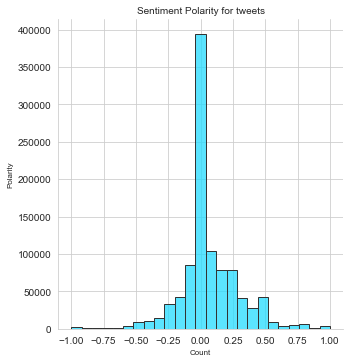

In [105]:
# distribution plot for content
sns.set_palette('cool')
sns.set_style("whitegrid")
figure( dpi=250)
sns.displot(df, x=df['polarity_text'], bins=25, edgecolor=".2")

# custom labels
plt.xlabel("Count", fontsize= 8)
plt.ylabel("Polarity", fontsize= 8)
plt.title('Sentiment Polarity for tweets', fontsize= 10)

Text(0.5, 1.0, 'Text length(Char) for tweets')

<Figure size 900x600 with 0 Axes>

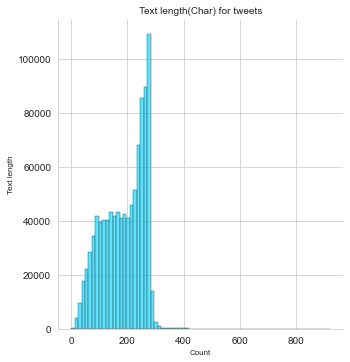

In [106]:
# # distribution plot for content text length
figure( dpi=150)
sns.displot(df, x=df['review_len_text'], bins=75,edgecolor=".2")

# custom labels
plt.xlabel("Count", fontsize= 8)
plt.ylabel("Text length", fontsize= 8)
plt.title('Text length(Char) for tweets', fontsize= 10)


Text(0.5, 1.0, 'Word Count for tweets')

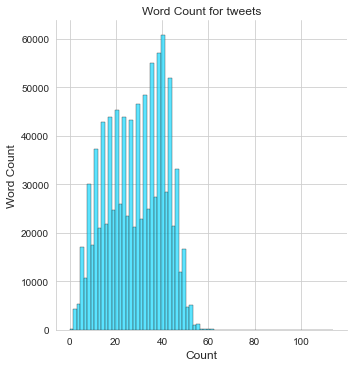

In [107]:
# distribution plot for tweet characters
sns.displot(df, x=df['word_count_text'], bins=75, edgecolor=".2")

# custom labels
plt.xlabel("Count", fontsize= 12)
plt.ylabel("Word Count", fontsize= 12)
plt.title('Word Count for tweets', fontsize= 12)



In [108]:
from nltk.corpus import stopwords
stop_words_ = stopwords.words('english')
stop_words_.extend(['amp','www','https ','http','https', 'amp ','co','tco','&amp;','&amp','-'])


In [109]:
#distribution of top unigrams after removing stop words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = stop_words_).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['text_processed'], 30)

for word, freq in common_words:
    print(word, freq)
    
df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])




ukraine 605041
russia 299037
russian 238575
war 138877
ukrainian 137233
putin 121662
standwithukraine 111633
people 92237
us 75764
mariupol 70800
world 69977
nato 67077
forces 54048
news 50251
kyiv 49152
one 48671
today 47487
military 43833
tigray 40819
support 40403
ukrainerussiawar 40047
children 36112
russians 36052
ukrainewar 35990
stop 35779
like 35282
killed 34828
eu 34612
help 33379
region 33354


In [110]:
sns.set_style("whitegrid")
a4_dims = (14,8)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(ax=ax,x="text", y='count', data=df1,palette='plasma', edgecolor=".3")
# custom labels
plt.xticks(rotation = 45,fontsize=12)
plt.xlabel("Words", fontsize= 12)
plt.ylabel("Count", fontsize= 12)
plt.title('Top 20 words in tweets after removing stop words', fontsize= 14)

Text(0.5, 1.0, 'Top 20 words in tweets after removing stop words')

russia ukraine 27766
ukraine russia 25562
war ukraine 23465
invasion ukraine 13517
armed forces 12317
russian forces 11753
ukrainian forces 11212
glory ukraine 10597
russian army 10196
war crimes 10085
support ukraine 10049
ukraine ukrainian 9385
russian troops 8728
ukraine war 8544
ukraine russian 8469
ukraine ukrainerussiawar 8138
russian soldiers 7903
forces ukraine 7795
ukraine needs 7671
year old 7664


Text(0.5, 1.0, 'Top Bigrams for Details after removing stop words')

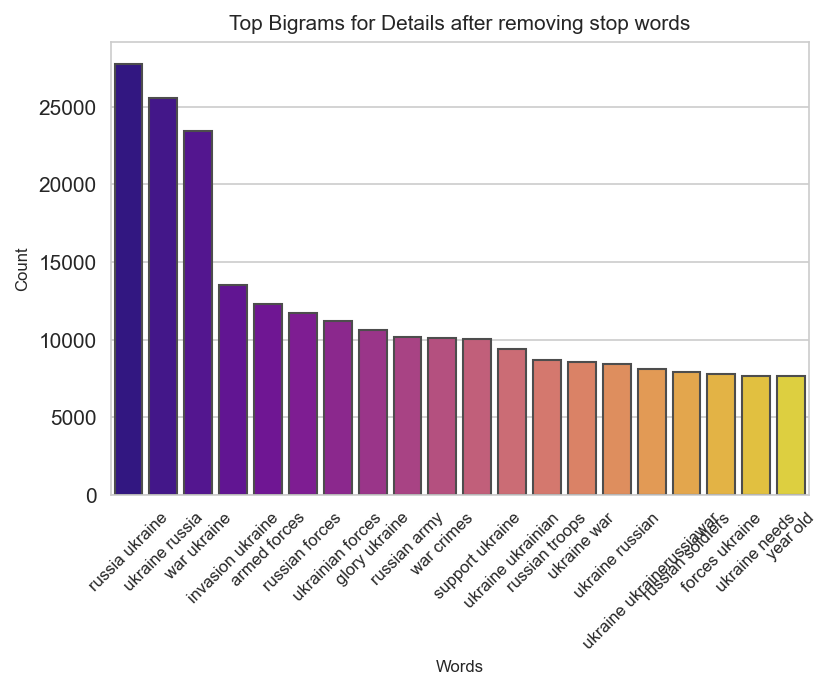

In [111]:
# top bigrams after removing stop words
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words=stop_words_).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['text_processed'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['text' , 'count'])

sns.set_style("whitegrid")
figure( dpi=150)
sns.barplot(x="text", y='count', data=df2, palette='plasma', edgecolor=".3")
# custom labels
plt.xticks(rotation = 45,fontsize=8)
plt.xlabel("Words", fontsize= 8)
plt.ylabel("Count", fontsize= 8)
plt.title('Top Bigrams for Details after removing stop words', fontsize= 10)


armed forces ukraine 6475
ukraine needs weapons 5042
humanitarian assistance defend 4560
weapons humanitarian assistance 4556
needs weapons humanitarian 4554
assistance defend putin 4547
stop innocent civilian 4525
innocent civilian deaths 4525
potus provide safeairliftukraine 4470
defend putin stop 4208
putin stop innocent 4206
russia invasion ukraine 4146
civilian deaths potus 4141
deaths potus provide 4138
provide safeairliftukraine stopputin 4041
defence intelligence update 3621
latest defence intelligence 3603
update situation ukraine 3602
intelligence update situation 3591
uk government response 3581


Text(0.5, 1.0, 'Top trigrams for tweets after removing stop words')

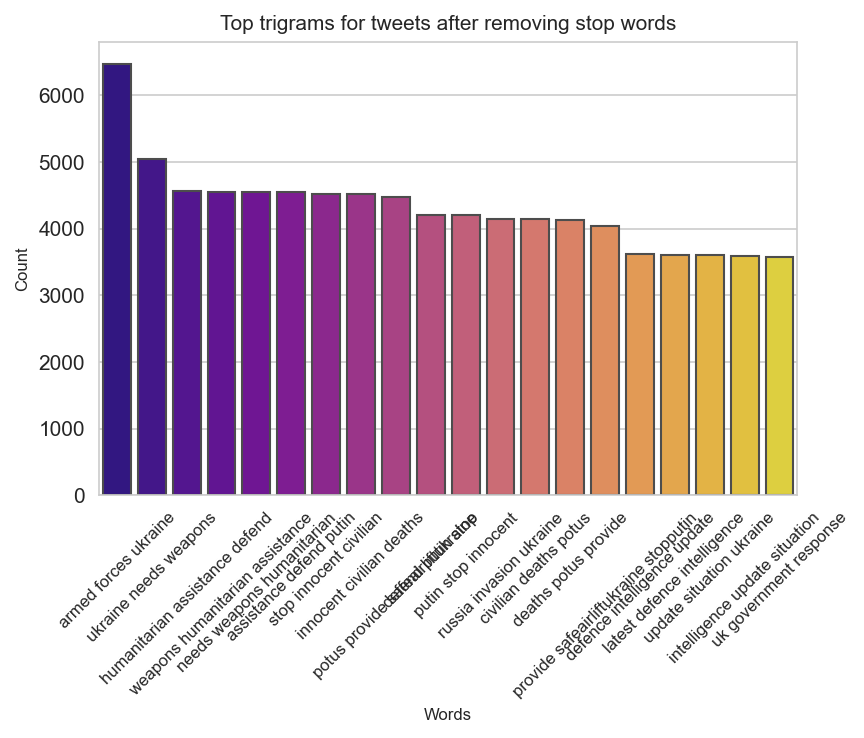

In [115]:
# top trigrams after removing stop words
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words=stop_words_).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['text_processed'], 20)
for word, freq in common_words:
    print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['text' , 'count'])

sns.set_style("whitegrid")
figure( dpi=150)
sns.barplot(x="text", y='count', data=df3, palette='plasma', edgecolor=".3")
# custom labels
plt.xticks(rotation = 45,fontsize=8)
plt.xlabel("Words", fontsize= 8)
plt.ylabel("Count", fontsize= 8)
plt.title('Top trigrams for tweets after removing stop words', fontsize= 10)


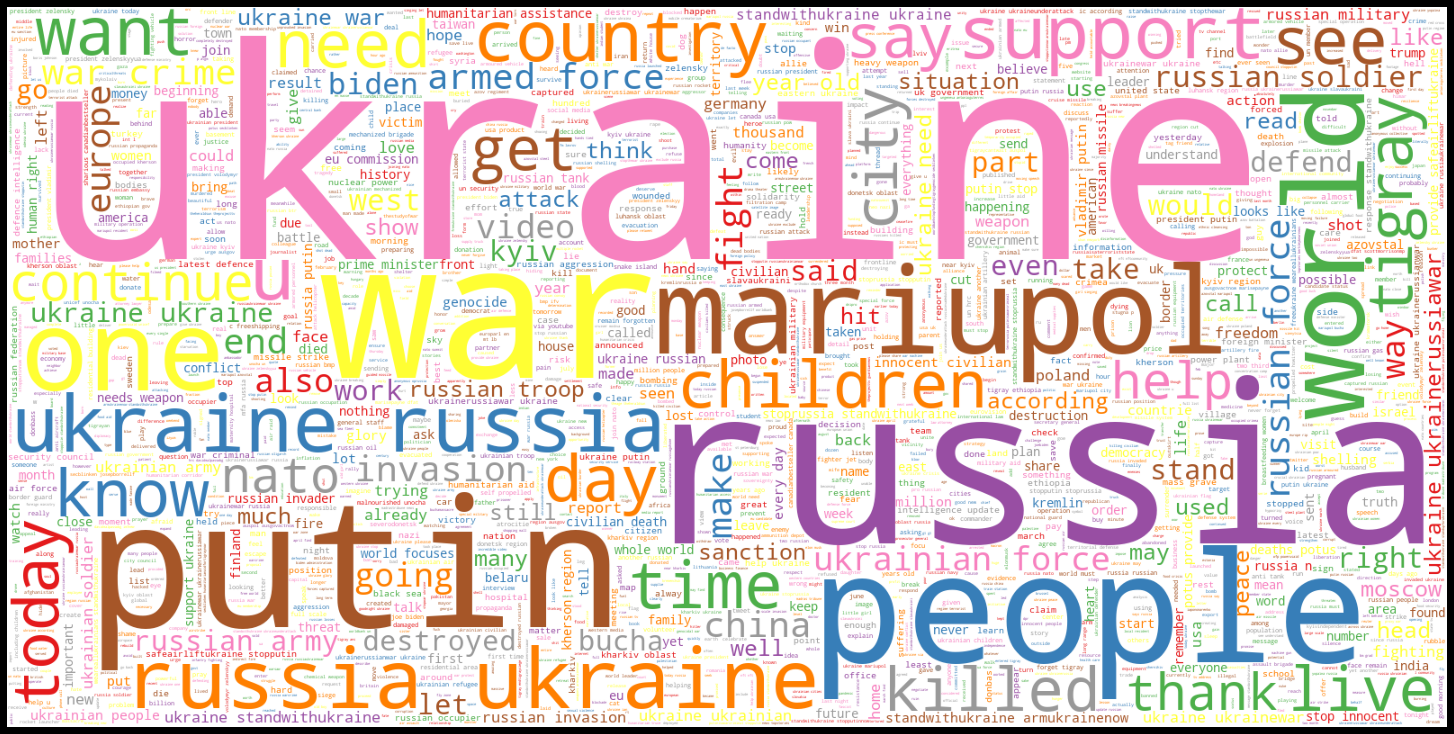

In [116]:
# Import the wordcloud library
from wordcloud import WordCloud



# Join the different processed titles together.
long_string = ','.join(list(df['text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(stopwords = stop_words_, max_words=5000, width=1600, height=800, background_color='white', colormap='Set1').generate(long_string)

# # Generate a word cloud
# wordcloud.generate(long_string)

# # Visualize the word cloud
# wordcloud.to_image()
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# LDA

In [114]:
df['stopwords_removed'] = df['text_processed'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop_words_))
df['stopwords_removed']
#format training data to list of strings
training_data = [' '.join(t.split()) for t in df['stopwords_removed'].tolist()]

print(type(training_data))
print(np.array(training_data).shape)
training_data[:10]


<class 'list'>
(1000000,)


['russia authorities rostov heavily militarized city close border ukraine started refurbishing person soviet era bomb shelter',
 'intlcrimcourt courpenaleint warcrimes nl putinhuilo putinhitler warcrimes putinswar standwithukraine️ stopputinnow svpol seizeputinsassets 🇷🇺 russia blockputinwallets 🇷🇺 ukraine 🇺🇦 ukraina ❤ svfm säkpol putinisawarcriminal 🇷🇺 ukraineisunderattack',
 'ukraine another stugna p atgm strike ukrainian air assault brigade recent days russian vehicle either tank bmp destroyed',
 'president ukraine🇺🇦 zelenskyyua addresses un security council russia feels like colonizer bucha one many examples 🇷🇺cruelty war crimes ukraine justice cannot escaped must hold russia accountable',
 'top cryptocurrencies watch week btc algo atom xtz egld russia trading binance ripple',
 'ukraine ukrainian tractor brigades made return time borrowing gvozdika spg russian forces',
 'russia ns clearly interested burying bodies dead several days probably even weeks eyeballs anymore also huge hyg

In [44]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))
    
corpus = [row.split()for row in training_data]
dirichlet_dict = corpora.Dictionary(corpus)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in corpus]




I is 27


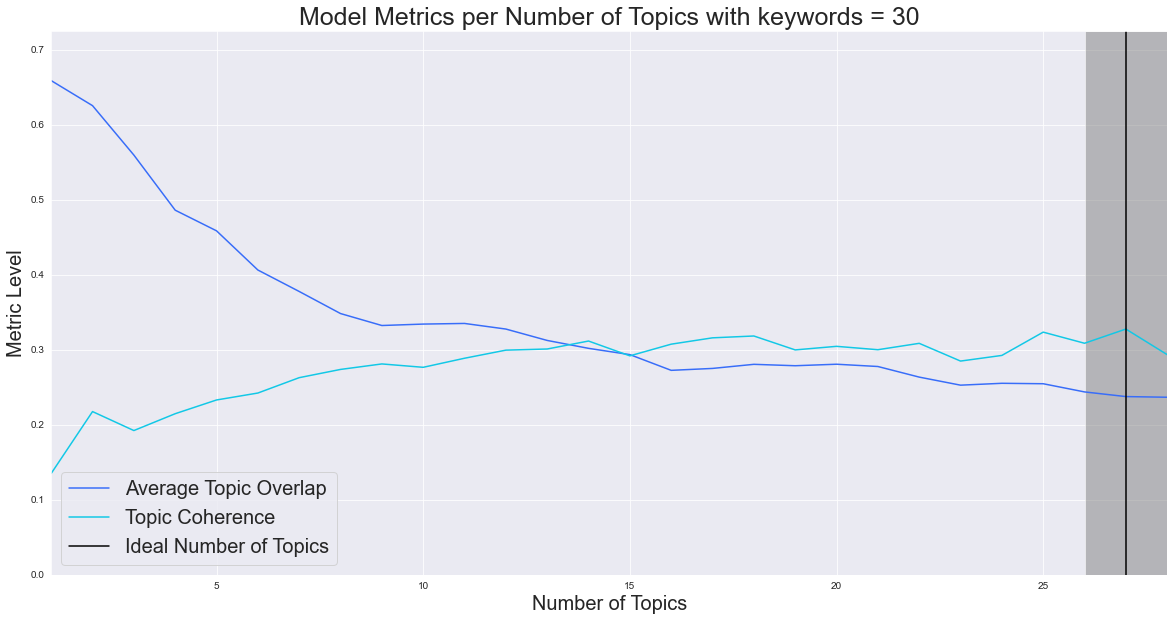

I is 27


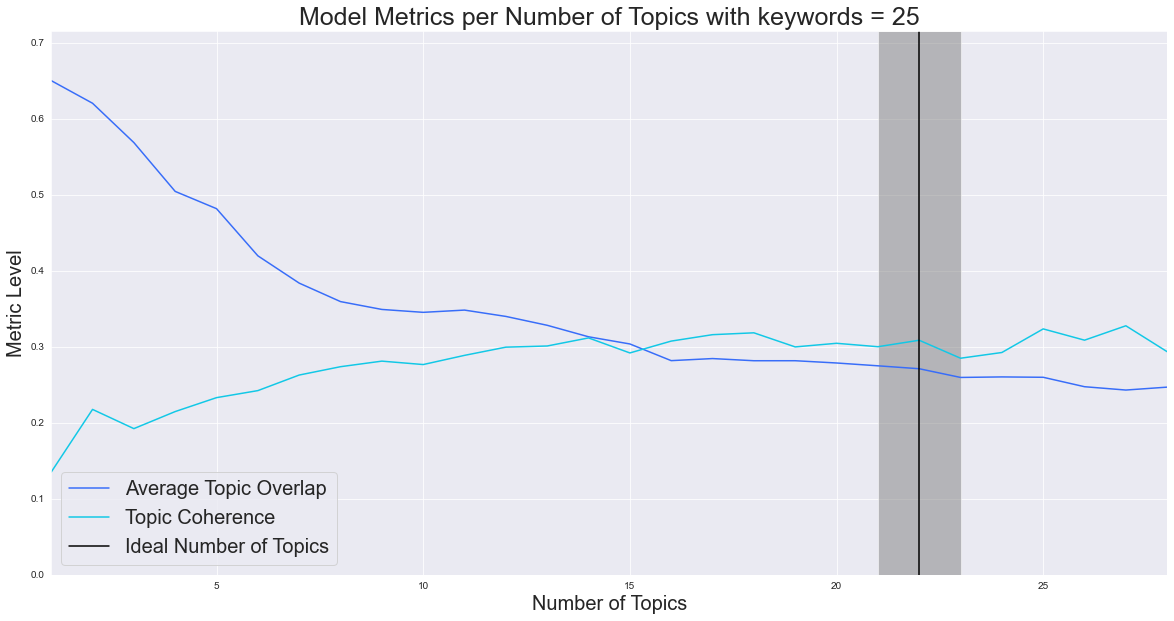

I is 27


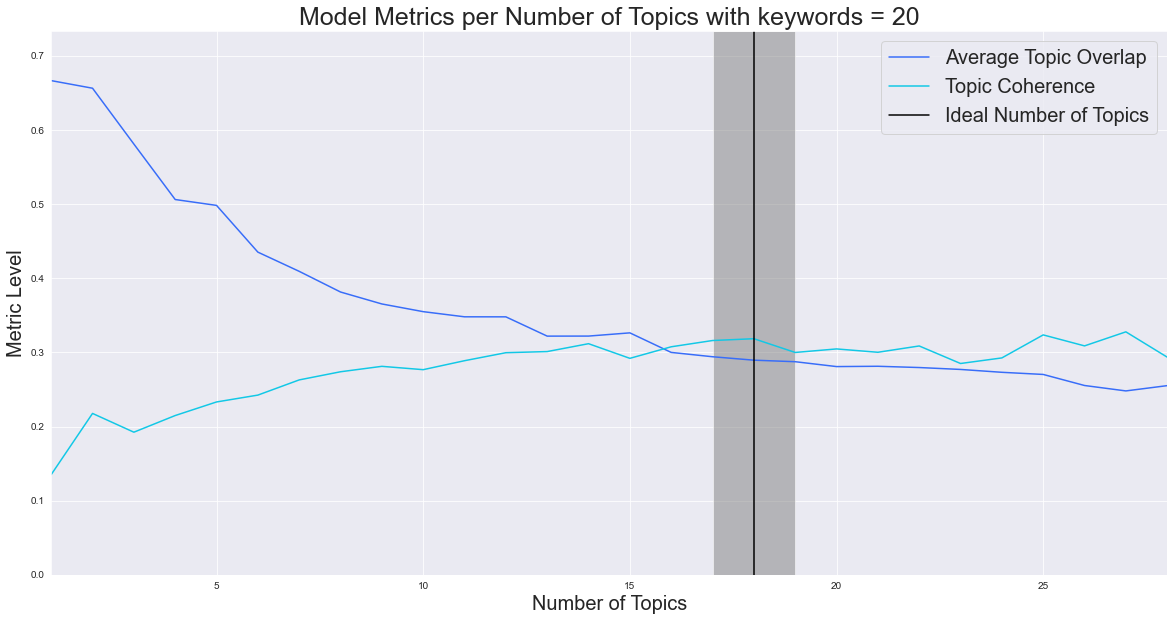

I is 27


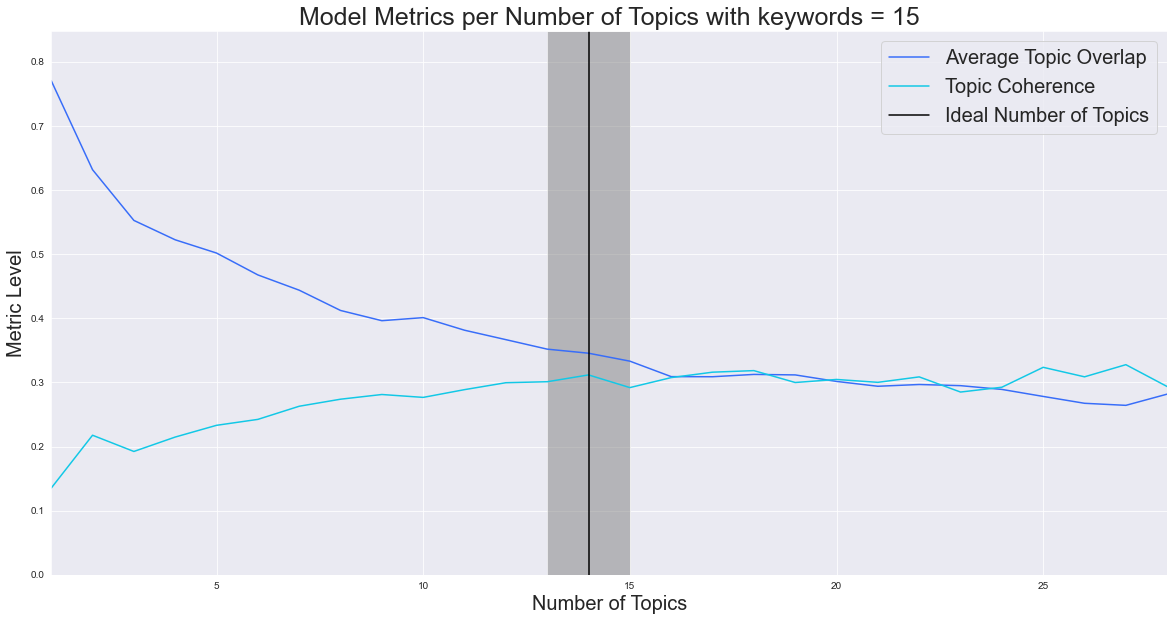

In [32]:
sns.set_style("darkgrid")
sns.set_palette("rainbow")

# Considering 1-10 topics, as the last is cut off
num_topics = list(range(30)[1:])

for num_keywords in range(30, 14, -5):

  LDA_models = {}
  LDA_topics = {}
  for i in num_topics:
      LDA_models[i] = LdaModel(corpus=bow_corpus,
                              id2word=dirichlet_dict,
                              num_topics=i,
                              update_every=1,
                              chunksize=len(bow_corpus),
                              passes=20,
                              alpha='auto',
                              random_state=42)

      shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                              num_words=num_keywords,
                                              formatted=False)
      LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

  LDA_stability = {}
  for i in range(0, len(num_topics)-1):
      jaccard_sims = []
      for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
          sims = []
          for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
              sims.append(jaccard_similarity(topic1, topic2))    
          
          jaccard_sims.append(sims)    
      
      LDA_stability[num_topics[i]] = jaccard_sims
                  
  mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]
  print(f"I is {i}")
  coherences = [CoherenceModel(model=LDA_models[i], texts=corpus, dictionary=dirichlet_dict, coherence='c_v').get_coherence()\
          for i in num_topics[:-1]]

  coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] if num_keywords < len(num_topics) else [coherences[i] - mean_stabilities[i] for i in range(len(num_topics))[:-1]]
  # limit topic numbers to the number of keywords

  coh_sta_max = max(coh_sta_diffs)
  coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
  ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
  ideal_topic_num = num_topics[ideal_topic_num_index]

  plt.figure(figsize=(20,10))
  ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
  ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

  ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
  ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

  y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
  ax.set_ylim([0, y_max])
  ax.set_xlim([1, num_topics[-1]-1])
                  
  ax.axes.set_title('Model Metrics per Number of Topics with keywords = '+ str(num_keywords), fontsize=25)
  ax.set_ylabel('Metric Level', fontsize=20)
  ax.set_xlabel('Number of Topics', fontsize=20)
  plt.legend(fontsize=20)
  plt.show()

      

In [117]:
lda_model_final =LdaModel(corpus=bow_corpus,
                              id2word=dirichlet_dict,
                              num_topics=14,
                              update_every=1,
                              chunksize=len(bow_corpus),
                              passes=20,
                              alpha='auto',
                              random_state=42)
# Print the Keyword in the 10 topics
from pprint import pprint
pprint(lda_model_final.print_topics())
doc_lda = lda_model_final[bow_corpus]

[(0,
  '0.012*"#ukraine" + 0.008*"#russia" + 0.006*"&amp;" + 0.006*"russian" + '
  '0.004*"people" + 0.004*"ukrainian" + 0.003*"president" + 0.003*"-" + '
  '0.003*"#mariupol" + 0.003*"#putin"'),
 (1,
  '0.021*"#ukraine" + 0.011*"#russia" + 0.009*"war" + 0.007*"russian" + '
  '0.006*"#putin" + 0.006*"ukraine" + 0.006*"children" + 0.005*"putin" + '
  '0.005*"world" + 0.005*"#nato"'),
 (2,
  '0.024*"#ukraine" + 0.009*"&amp;" + 0.007*"war" + 0.006*"ukraine" + '
  '0.006*"#ukrainerussiawar" + 0.005*"russia" + 0.005*"people" + '
  '0.005*"#russia" + 0.004*"#standwithukraine" + 0.004*"#mariupol"'),
 (3,
  '0.019*"#ukraine" + 0.008*"-" + 0.007*"#russia" + 0.007*"&amp;" + '
  '0.005*"russian" + 0.005*"war" + 0.004*"#news" + 0.004*"russia" + 0.002*"|" '
  '+ 0.002*"ukraine"'),
 (4,
  '0.025*"#ukraine" + 0.012*"russian" + 0.010*"#russia" + 0.007*"ukrainian" + '
  '0.007*"forces" + 0.006*"#russian" + 0.006*"region" + 0.004*"ukraine" + '
  '0.004*"#kharkiv" + 0.004*"city"'),
 (5,
  '0.012*"#ukrain

In [118]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_final, bow_corpus, dirichlet_dict, mds="mmds", R=15)
vis

C:\Users\Administrator\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.159236  0.146824       1        1  10.655094
7     -0.031830  0.021354       2        1  10.125764
1     -0.162521 -0.030067       3        1  10.033127
4      0.020481 -0.069557       4        1   9.530992
12    -0.168703  0.054787       5        1   8.156455
2      0.111753 -0.091556       6        1   7.320909
9      0.180390 -0.053369       7        1   7.017583
8      0.151756  0.043103       8        1   6.299015
3      0.049121  0.161693       9        1   5.723224
0      0.061022 -0.189277      10        1   5.525299
11    -0.159331 -0.135796      11        1   5.448477
10    -0.056460 -0.169809      12        1   5.085750
5     -0.032181  0.165989      13        1   4.817727
13    -0.122733  0.145682      14        1   4.260583, topic_info=                  Term        Freq       Total Category  logprob  loglift
368          #ukraine:  278.000000  278.000000  Default  15.0000  15.0000
5               forces  446.000000  446.000000  Default  14.0000  14.0000
197                  -  878.000000  878.000000  Default  13.0000  13.0000
223                 🇺🇦  419.000000  419.000000  Default  12.0000  12.0000
306  #standwithukraine  820.000000  820.000000  Default  11.0000  11.0000
..                 ...         ...         ...      ...      ...      ...
514         government   14.925446  110.951085  Topic14  -6.2910   1.1497
84           ukrainian   25.766286  798.254340  Topic14  -5.7450  -0.2776
151          #mariupol   19.059141  378.254902  Topic14  -6.0465   0.1677
547              world   18.271270  527.992300  Topic14  -6.0887  -0.2080
88              #putin   17.694614  503.001271  Topic14  -6.1208  -0.1916

[590 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
3065       8  0.733882    "neptun"
6493      13  0.915491     "thanks
1590       2  0.164073  #anonymous
1590       3  0.567945  #anonymous
1590       4  0.012621  #anonymous
...      ...       ...         ...
26185     14  0.781881           🔸
8149      10  0.900255           😴
8149      12  0.090026           😴
29853     10  0.968616           🛌
4598       1  0.957469           🦁

[2133 rows x 3 columns], R=15, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 8, 2, 5, 13, 3, 10, 9, 4, 1, 12, 11, 6, 14])

In [119]:
perplexity = lda_model_final.log_perplexity(bow_corpus)
print(perplexity)

-9.356094643698098


# NMF

ideal_topic_num (when maxing divergence): 15
mean_stabilities: [0.4135254988913526, 0.2915826003830528, 0.17910258721339925, 0.143481544090284, 0.11633244975922809, 0.11031369187624937, 0.1026654759968453, 0.09041236932352421, 0.08185029586319904, 0.08191873228238881, 0.07684134914121807, 0.07323782976724172, 0.06754556960121103, 0.06398956672998178, 0.05963302322603386, 0.06036175514662115, 0.05614743085971455, 0.05465005278253117, 0.05771623095957563, 0.05471427513046838, 0.05180302824977925, 0.051009938637708134, 0.05169124185097029, 0.049423999490497174, 0.04614023049213802, 0.04803297375406214, 0.04606256463118997, 0.04463945942436086]
coherences: [0.14437165692478154, 0.208577317935658, 0.21362119178407343, 0.25460219498339665, 0.2917853793193344, 0.28713392328732973, 0.30073451492445796, 0.33257873002559757, 0.319710668667037, 0.29206087337528663, 0.31232531429469795, 0.32597763899353355, 0.32293593056905673, 0.33996310242225264, 0.34037394922015834, 0.3148038679170111, 0.317398

ideal_topic_num (when maxing divergence): 21
mean_stabilities: [0.7592592592592593, 0.2676942025465774, 0.17999041584549244, 0.14971878615710768, 0.1161748768475777, 0.10595936526893929, 0.08996460338481953, 0.08913109768696328, 0.08705348869991786, 0.0878283445657845, 0.07853969067104645, 0.06929925832479046, 0.0651887064104273, 0.06262019219971339, 0.06114767585037358, 0.05969436196790828, 0.057327581248300306, 0.057281522422863544, 0.055087803703774536, 0.052263335260685245, 0.0502994763702947, 0.049018433978708864, 0.04625521206671636, 0.04528953553638886, 0.04290582141585603, 0.04241895152804351, 0.04414341189575489, 0.04396879299960634]
coherences: [0.15545411022551783, 0.1723090423592537, 0.2927216641171794, 0.2888751281627975, 0.29986803533232875, 0.3330233598150345, 0.31910464080704315, 0.31093974342322506, 0.31685973768868136, 0.2829235626777086, 0.30587540571246924, 0.3132348119832287, 0.28795033247452434, 0.33972956387861014, 0.2950628065290512, 0.30580548999140955, 0.28741

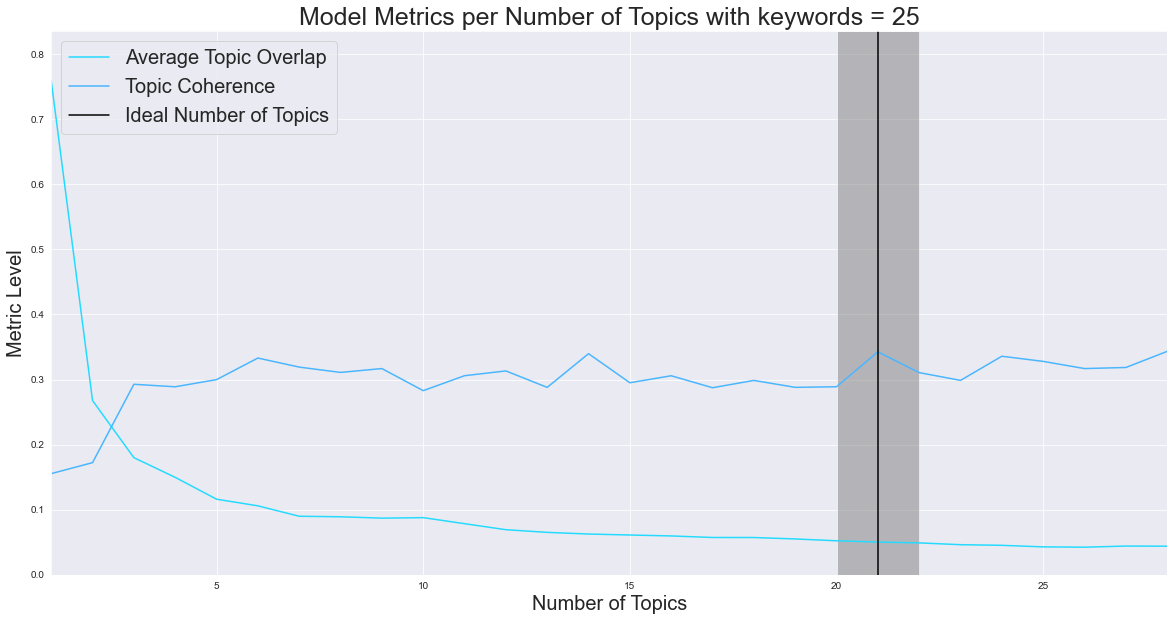

ideal_topic_num (when maxing divergence): 14
mean_stabilities: [0.48351648351648346, 0.3147544891148895, 0.21747168865290303, 0.13498786720335776, 0.11308828863258104, 0.10395353042768544, 0.08912383072180693, 0.08289561222137762, 0.07733176424042092, 0.07687112054048673, 0.07417685490788811, 0.06890003513525891, 0.06350572791136871, 0.05630853796524139, 0.05222763309063619, 0.05575041097271174, 0.05263400002543038, 0.051638201420239144, 0.049972496182160465, 0.04961097738867591, 0.047386891723993754, 0.048115062609159834, 0.04657994372505407, 0.04435140762563389, 0.041997918844287795, 0.04224459043119998, 0.03997563787653447, 0.03961812325877146]
coherences: [0.14437165692478157, 0.22872305791381065, 0.22304167407855693, 0.266033223764982, 0.31293441131019223, 0.2818999117192034, 0.32770534833196957, 0.3079254219897177, 0.32541482432131363, 0.32481373636209476, 0.34062381166517414, 0.30344450489404745, 0.310245482488929, 0.34515471121828517, 0.31741668139643026, 0.3050157418530346, 0.

ideal_topic_num (when maxing divergence): 6
mean_stabilities: [0.8198529411764706, 0.286231884057971, 0.18502968448620624, 0.12648379107149724, 0.09591055815193746, 0.09864290675492215, 0.09196648895594066, 0.07497504623941405, 0.0702459566827383, 0.07822971241301546, 0.07122039598017518, 0.0604295682213454, 0.061779203281666334, 0.055790746698864066, 0.04952622305508362, 0.055040292066264374, 0.05211139543903502, 0.04759676611579607, 0.046901411099312146, 0.04564026955331303, 0.04508980070858222, 0.04250303128324592, 0.041406474354967214, 0.040683203894223384, 0.03981809734843744, 0.03799382197715083, 0.038553284361050905, 0.03823967198255229]
coherences: [0.14437165692478163, 0.1638989949978814, 0.24407662287230725, 0.2891851402592579, 0.28408857434355267, 0.3687429563936684, 0.2741035856822335, 0.33833711425240853, 0.32180114008150795, 0.29780852562821347, 0.3126831449255352, 0.31079930437418496, 0.31312236309143004, 0.2968072564579094, 0.31316279588863977, 0.3066918336202583, 0.342

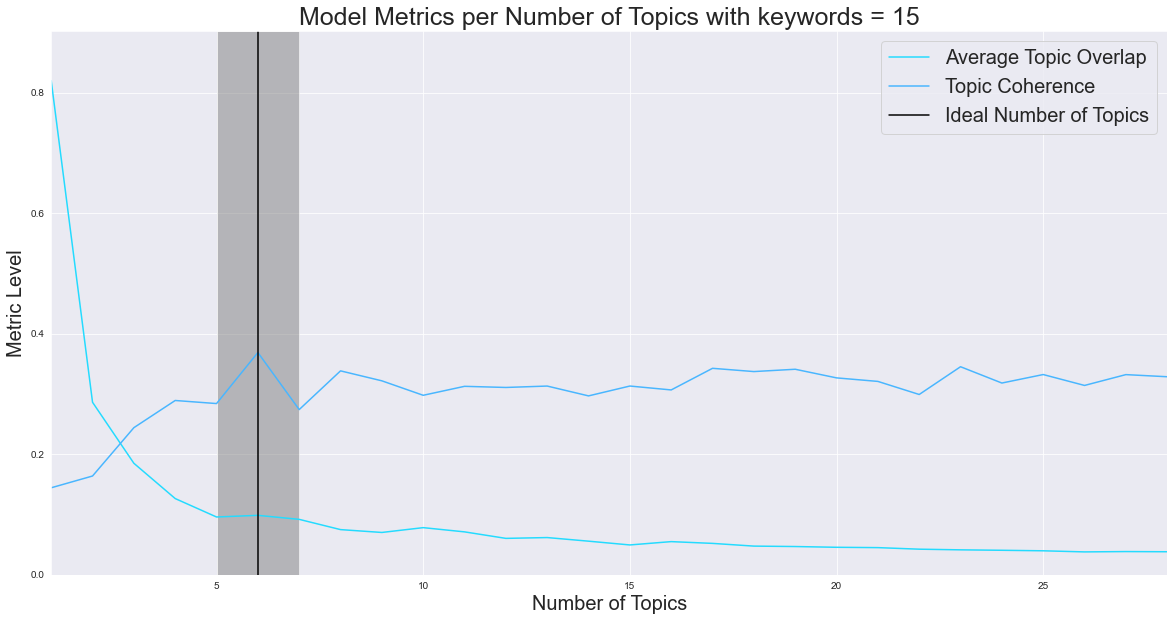

In [86]:
sns.set_style("darkgrid")
num_topics = list(range(30)[1:])
for num_keywords in range(30, 14, -5):

  nmf_models = {}
  nmf_topics = {}
  for i in num_topics:
      nmf_models[i] = Nmf(
          corpus=bow_corpus,
          num_topics=i,
          id2word=dirichlet_dict,
          chunksize=2000,
          passes=5,
          kappa=.1,
          minimum_probability=0.01,
          w_max_iter=300,
          w_stop_condition=0.0001,
          h_max_iter=100,
          h_stop_condition=0.001,
          eval_every=10,
          normalize=True
      )

      shown_topics = nmf_models[i].show_topics(num_topics=i, 
                                              num_words=num_keywords,
                                              formatted=False)
      nmf_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

  nmf_stability = {}
  for i in range(0, len(num_topics)-1):
      jaccard_sims = []
      for t1, topic1 in enumerate(nmf_topics[num_topics[i]]): # pylint: disable=unused-variable
          sims = []
          for t2, topic2 in enumerate(nmf_topics[num_topics[i+1]]): # pylint: disable=unused-variable
              sims.append(jaccard_similarity(topic1, topic2))    
          
          jaccard_sims.append(sims)    
      
      nmf_stability[num_topics[i]] = jaccard_sims
                  
  mean_stabilities = [np.array(nmf_stability[i]).mean() for i in num_topics[:-1]]

  coherences = [CoherenceModel(model=nmf_models[i], texts=corpus, dictionary=dirichlet_dict, coherence='c_v').get_coherence() for i in num_topics[:-1]]

  coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] if num_keywords < len(num_topics) else [coherences[i] - mean_stabilities[i] for i in range(len(num_topics))[:-1]]
  
  coh_sta_max = max(coh_sta_diffs)
  coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
  ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
  ideal_topic_num = num_topics[ideal_topic_num_index]

  print('ideal_topic_num (when maxing divergence):', ideal_topic_num)
  print('mean_stabilities:', mean_stabilities)
  print('coherences:', coherences)

  plt.figure(figsize=(20,10))
  ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
  ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

  ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
  ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

  y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
  ax.set_ylim([0, y_max])
  ax.set_xlim([1, num_topics[-1]-1])
                  
  ax.axes.set_title('Model Metrics per Number of Topics with keywords = '+ str(num_keywords), fontsize=25)
  ax.set_ylabel('Metric Level', fontsize=20)
  ax.set_xlabel('Number of Topics', fontsize=20)
  plt.legend(fontsize=20)
  plt.show()  

In [120]:
NMF_Final = Nmf(
          corpus=bow_corpus,
          num_topics=6,
          id2word=dirichlet_dict,
          chunksize=2000,
          passes=5,
          kappa=.1,
          minimum_probability=0.01,
          w_max_iter=300,
          w_stop_condition=0.0001,
          h_max_iter=100,
          h_stop_condition=0.001,
          eval_every=10,
          normalize=True
      )
# Print the Keyword in the 10 topics
from pprint import pprint
pprint(NMF_Final.print_topics())
doc_NMF = NMF_Final[bow_corpus]



[(0,
  '0.041*"#russia" + 0.032*"russia" + 0.017*"&amp;" + 0.015*"#ukraine" + '
  '0.009*"#putin" + 0.007*"us" + 0.006*"children" + 0.006*"#mariupol" + '
  '0.005*"says" + 0.004*"see"'),
 (1,
  '0.025*"people" + 0.024*"ukrainian" + 0.012*"#standwithukraine" + 0.010*"us" '
  '+ 0.010*"ukraine" + 0.008*"support" + 0.008*"need" + 0.008*"forces" + '
  '0.008*"help" + 0.006*"killed"'),
 (2,
  '0.041*"-" + 0.033*"russian" + 0.028*"&amp;" + 0.013*"#russian" + '
  '0.010*"#ukraine" + 0.009*"forces" + 0.008*"#ukraine:" + 0.006*"ukrainian" + '
  '0.006*"destroyed" + 0.006*"army"'),
 (3,
  '0.096*"#ukraine" + 0.016*"#russia" + 0.006*"russian" + 0.005*"military" + '
  '0.005*"#russian" + 0.005*"region" + 0.005*"said" + '
  '0.005*"#ukrainerussiawar" + 0.004*"today" + 0.004*"#kyiv"'),
 (4,
  '0.065*"war" + 0.020*"russian" + 0.010*"stop" + 0.008*"today" + '
  '0.006*"crimes" + 0.006*"city" + 0.004*"people" + 0.003*"want" + '
  '0.003*"lives" + 0.003*"don’t"'),
 (5,
  '0.038*"ukraine" + 0.020*"world"

# BTM

100%|██████████| 1000000/1000000 [02:05<00:00, 7985.68it/s]


ideal_topic_num (when maxing divergence): 3
mean_stabilities: [0.5394736842105263, 0.41890174509520123, 0.34356967026240276, 0.2843790844802087, 0.2596961263903519, 0.2508133175045483, 0.22320797840451448, 0.21138553738423294, 0.19498354997644024, 0.19024847526338126, 0.18689166889985623, 0.19050096691144633, 0.1776235559856081, 0.16836465331494369, 0.1740391357804261, 0.1695899169829176, 0.1591108659538735, 0.15870836048864329, 0.16219026033793513, 0.1633424958843894, 0.16118952637264816, 0.15801411212186792, 0.15165392620172866, 0.1529891513010855, 0.15122776923453282, 0.14555478143525694, 0.136590546841452, 0.13096166820745053]
coherences: [-598.1920160699087, -592.0847913771995, -578.9246902525005, -582.6258076234982, -595.1094537542938, -599.6288291275596, -590.8128117595742, -598.7044003183776, -607.0496085866057, -606.0405838891736, -613.4438113272959, -605.8446145630484, -617.7265446235318, -615.8267552759542, -608.6730118454294, -630.081558751893, -629.7755411113855, -627.0981

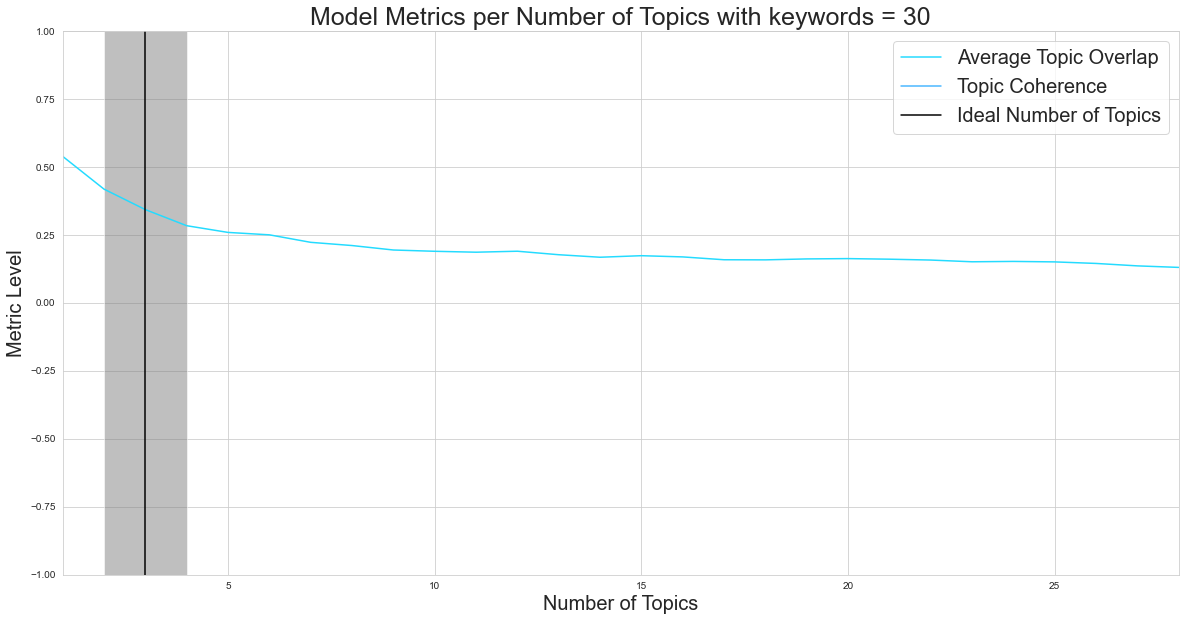

100%|██████████| 1000000/1000000 [01:47<00:00, 9293.50it/s]


KeyboardInterrupt: 

In [121]:

num_topics = list(range(30)[1:])
for num_keywords in range(30, 14, -5):

  X, vocabulary, vocab_dict = btm.get_words_freqs(training_data, stop_words=stop_words_)
  docs_vec = btm.get_vectorized_docs(training_data, vocabulary)
  biterms = btm.get_biterms(docs_vec)

  btm_models = {}
  btm_topics = {}
  for i in num_topics:
      btm_models[i] = btm.BTM(X, vocabulary, seed=12321, T=i, M=20, alpha=50/8, beta=0.01)
      btm_models[i].fit(biterms, iterations=20)

      p_zd = btm_models[i].transform(docs_vec)

      top_words = btm.get_top_topic_words(btm_models[i],words_num=num_keywords)
      btm_topics[i] = top_words.T.values.tolist()

  btm_stability = {}
  for i in range(0, len(num_topics)-1):
      jaccard_sims = []
      for t1, topic1 in enumerate(btm_topics[num_topics[i]]): # pylint: disable=unused-variable
          sims = []
          for t2, topic2 in enumerate(btm_topics[num_topics[i+1]]): # pylint: disable=unused-variable
              sims.append(jaccard_similarity(topic1, topic2))    
          
          jaccard_sims.append(sims)    
      
      btm_stability[num_topics[i]] = jaccard_sims
                  
  mean_stabilities = [np.array(btm_stability[i]).mean() for i in num_topics[:-1]]
  coherences = [np.mean(btm_models[i].coherence_) for i in num_topics[:-1]]
  perplexities = [btm_models[i].perplexity_ for i in num_topics[:-1]]

  coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(len(num_topics)-1)] 
  coh_sta_max = max(coh_sta_diffs)
  coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
  ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
  ideal_topic_num = num_topics[ideal_topic_num_index]

  print('ideal_topic_num (when maxing divergence):', ideal_topic_num)
  print('mean_stabilities:', mean_stabilities)
  print('coherences:', coherences)

  plt.figure(figsize=(20,10))
  ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
  ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

  ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
  ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

  y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
  ax.set_ylim([-1, 1])
  ax.set_xlim([1, num_topics[-1]-1])
                  
  ax.axes.set_title('Model Metrics per Number of Topics with keywords = '+ str(num_keywords), fontsize=25)
  ax.set_ylabel('Metric Level', fontsize=20)
  ax.set_xlabel('Number of Topics', fontsize=20)
  plt.legend(fontsize=20)
  plt.show()  

In [ ]:
X, vocabulary, vocab_dict = btm.get_words_freqs(training_data, stop_words=stop_words_)
docs_vec = btm.get_vectorized_docs(training_data, vocabulary)
biterms = btm.get_biterms(docs_vec)

final_btm_model = btm.BTM(X, vocabulary, seed=12321, T=i, M=20, alpha=50/8, beta=0.01)
final_btm_model.fit(biterms, iterations=20)

p_zd = final_btm_model.transform(docs_vec)

top_words = btm.get_top_topic_words(final_btm_model,words_num=num_keywords)
btm_topics = top_words.T.values.tolist()
btm_topics

In [ ]:
top_words

topic0     topic1            topic2            topic3  \
0           tigray    russian           ukraine           ukraine   
1               un    ukraine            russia           russian   
2              aid     russia               war            russia   
3            world  ukrainian            people         ukrainian   
4   endtigraysiege     region             putin  standwithukraine   
5         ethiopia       city         ukrainian             putin   
6     humanitarian       kyiv  standwithukraine            forces   
7       secblinken     killed              said                uk   
8               ic   russians                us         situation   
9             must    kherson          russians               war   
10            food  civilians             never        government   
11  tigraygenocide   mariupol             world            latest   
12        millions    kharkiv               see            update   
13             wfp     people            please      intelligence   
14              eu     forces             today           defence   

              topic4     topic5          topic6       topic7  \
0            ukraine   mariupol         ukraine      ukraine   
1   standwithukraine     people          russia       russia   
2            russian    ukraine            nato          war   
3             russia       city              eu           us   
4                old   children         russian     business   
5          ukrainian     russia              un      russian   
6               kyiv    russian             war         nato   
7              bucha     killed           putin       people   
8             killed   azovstal              us     mariupol   
9         stoprussia  ukrainian        security         stop   
10        ukrainians      women           potus      weapons   
11          genocide  civilians  emmanuelmacron      country   
12              year       many           world  destruction   
13        stopthewar       dead       president       become   
14       freeukraine       year          people        today   

              topic8            topic9  ...    topic17           topic18  \
0                nft           ukraine  ...    ukraine           ukraine   
1            ukraine              like  ...        war            russia   
2             crypto  standwithukraine  ...     russia               war   
3             russia               war  ...    russian           russian   
4            bitcoin               get  ...      putin             putin   
5               nfts         ukrainian  ...     people              city   
6                usa               may  ...  civilians              news   
7               news            people  ...     killed            people   
8            support          mariupol  ...      bucha               one   
9             follow        ukrainewar  ...   children          mariupol   
10                rt              help  ...     crimes  standwithukraine   
11               btc             still  ...         us             human   
12  standwithukraine            russia  ...  ukrainian             world   
13               eth            please  ...   soldiers         ukrainian   
14          giveaway              need  ...       even          invasion   

       topic19    topic20           topic21    topic22    topic23    topic24  \
0      ukraine    ukraine           ukraine    ukraine    ukraine    russian   
1      russian     russia            russia     russia    russian    ukraine   
2    ukrainian    russian           support       nato     russia  ukrainian   
3       russia        war               war         us  ukrainian     forces   
4       forces      putin              help      china   mariupol     russia   
5        close  anonymous               day        war     forces  destroyed   
6     business         us  standwithukraine         eu       army     oblast   
7    destroyed      state

# Corex

In [124]:
import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt
import corextopic.corextopic as ct
import corextopic.vis_topic as vt # jupyter notebooks will complain matplotlib is being loaded twice



In [125]:
vectorizer = CountVectorizer(stop_words=stop_words_, max_features=20000, binary=True)
doc_word = vectorizer.fit_transform(training_data)
doc_word = ss.csr_matrix(doc_word)

doc_word.shape

(1000000, 20000)

In [127]:
words = list(np.asarray(vectorizer.get_feature_names()))
not_digit_inds = [ind for ind,word in enumerate(words) if not word.isdigit()]
doc_word = doc_word[:,not_digit_inds]
words    = [word for ind,word in enumerate(words) if not word.isdigit()]

doc_word.shape

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(1000000, 20000)

In [128]:
# Train the CorEx topic model with 50 topics
topic_model = ct.Corex(n_hidden=50, words=words, max_iter=200, verbose=False, seed=1)
topic_model.fit(doc_word, words=words);

In [129]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: tigray, ethiopia, tigraygenocide, endtigraysiege, secblinken, humanitarian, ic, potus, unocha, wfp
1: killed, children, bucha, women, old, civilians, bodies, dead, died, mother
2: nft, nfts, anonymous, crypto, oprussia, nftcommunity, giveaway, bitcoin, eth, cryptocurrency
3: vehicles, vehicle, bmp, armored, drone, btr, propelled, atgm, armoured, howitzers
4: news, business, marketing, technology, twitter, trending, breakingnews, tech, scotus, music
5: russian, oblast, kharkiv, region, kherson, donetsk, brigade, luhansk, shelling, fire
6: stopthewar, weareallukrainians, freeukraine, standtogether, gaza, water, gazaunderattack, animals, food, supportukraine
7: biden, trump, gop, joe, maga, cnn, america, democrats, foxnews, republicans
8: china, taiwan, india, usa, canada, chinese, pelosi, freeshipping, canadianbestseller, sharious
9: mariupol, azovstal, azov, savemariupol, defenders, plant, regiment, steel, theater, evacuation
10: sanctions, oil, energy, economic, global, prices, econ

In [130]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [131]:
# Train the CorEx topic model with 25 topics
topic_model = ct.Corex(n_hidden=25, words=words, max_iter=200, verbose=False, seed=1)
topic_model.fit(doc_word, words=words);

In [132]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: tigray, ethiopia, tigraygenocide, endtigraysiege, secblinken, ic, unocha, wfp, focuses, ethiopian
1: russian, ukrainian, destroyed, oblast, ukraine, tank, artillery, brigade, captured, air
2: nft, nfts, safeairliftukraine, crypto, nftcommunity, assistance, provide, giveaway, weareallukrainians, bitcoin
3: business, china, gas, oil, anonymous, india, taiwan, oprussia, energy, prices
4: nato, biden, us, trump, eu, finland, sweden, countries, states, european
5: mariupol, city, azovstal, killed, azov, shelling, kharkiv, russians, wounded, mayor
6: crimes, innocent, mass, civilian, deaths, bodies, committed, rape, needs, weapons
7: children, women, mother, pregnant, raped, families, died, hospital, child, rip
8: minister, defence, prime, intelligence, foreign, response, situation, update, ministry, grain
9: old, year, girl, dog, boy, son, father, daughter, family, singing
10: un, rights, human, law, council, commission, international, community, members, syria
11: news, twitter, like, m

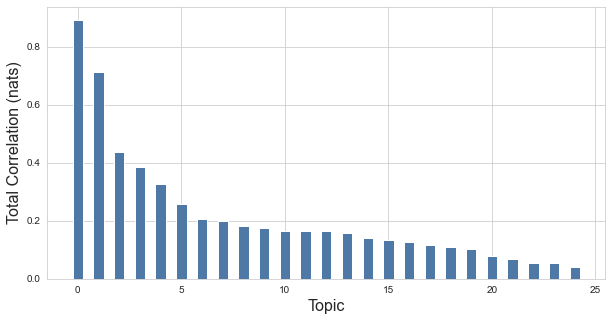

In [133]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [134]:
# Train the CorEx topic model with 25 topics
topic_model = ct.Corex(n_hidden=15, words=words, max_iter=200, verbose=False, seed=1)
topic_model.fit(doc_word, words=words);

In [135]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: tigray, ethiopia, tigraygenocide, endtigraysiege, un, humanitarian, secblinken, ic, unocha, wfp
1: forces, brigade, ukraine, tank, artillery, captured, armed, vehicles, vehicle, bmp
2: nft, nfts, crypto, nftcommunity, giveaway, bitcoin, weareallukrainians, eth, follow, cryptocurrency
3: children, old, women, bodies, mother, year, died, pregnant, hospital, families
4: nato, president, china, minister, finland, sweden, taiwan, us, prime, european
5: russia, putin, war, crimes, sanctions, nuclear, state, vladimir, kremlin, gas
6: biden, trump, gop, joe, democrats, scotus, like, maga, america, twitter
7: news, business, usa, india, canada, indian, pakistan, students, israel, breakingnews
8: potus, eu, stop, provide, assistance, weapons, needs, commission, support, defend
9: russian, ukrainian, destroyed, killed, kherson, soldiers, civilians, army, occupied, troops
10: mariupol, city, azovstal, kharkiv, donetsk, oblast, region, azov, kyiv, luhansk
11: people, standwithukraine, armukraine

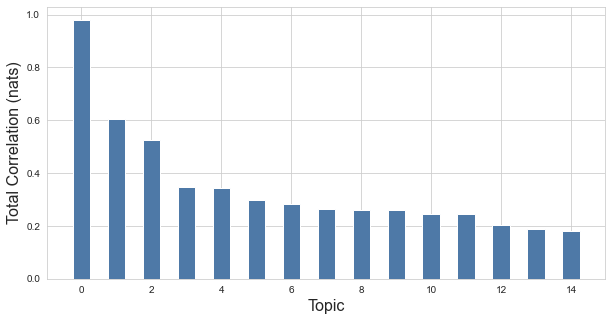

In [136]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

# Semi supervised

In [141]:
anchor_words = ['ukraine', 'tigray','nato',  ['russians', 'russia']]

anchored_topic_model = ct.Corex(n_hidden=15, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

In [142]:
# Print all topics from the CorEx topic model
topics = anchored_topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: ukraine, invasion, glory, poland, donated, stands, jointhelegion, goodnight, slovakia, digitalresistance
1: tigray, ethiopia, tigraygenocide, endtigraysiege, un, secblinken, humanitarian, ic, unocha, potus
2: nato, finland, sweden, alliance, jensstoltenberg, allies, membership, natosummit, wearenato, turkey
3: russia, russians, moscow, россия, invaded, lavrov, terrorist, tpyxa, detained, russiaukraineconflict
4: standwithukraine, anonymous, oprussia, freeukraine, stopthewar, weareallukrainians, putinisawarcriminal, stopputin, россиясмотри, standtogether
5: china, india, news, taiwan, uk, oil, usa, latest, indian, pakistan
6: eu, sanctions, countries, security, european, gas, international, must, rights, human
7: forces, destroyed, oblast, artillery, brigade, tank, air, missile, vehicles, hit
8: president, putin, biden, zelenskyyua, stop, weapons, us, trump, zelensky, democracy
9: mariupol, killed, azovstal, city, civilians, bucha, old, bodies, children, wounded
10: people, war, crim